The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

model_index.json:   0%|          | 0.00/537 [00:00<?, ?B/s]

Fetching 13 files:   0%|          | 0/13 [00:00<?, ?it/s]

(…)ure_extractor%2Fpreprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

tokenizer%2Fmerges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer%2Fvocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

text_encoder%2Fconfig.json:   0%|          | 0.00/633 [00:00<?, ?B/s]

tokenizer%2Ftokenizer_config.json:   0%|          | 0.00/824 [00:00<?, ?B/s]

tokenizer%2Fspecial_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.36G [00:00<?, ?B/s]

scheduler%2Fscheduler_config.json:   0%|          | 0.00/345 [00:00<?, ?B/s]

unet%2Fconfig.json:   0%|          | 0.00/939 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.46G [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

vae%2Fconfig.json:   0%|          | 0.00/611 [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Generated 5 thumbnails.


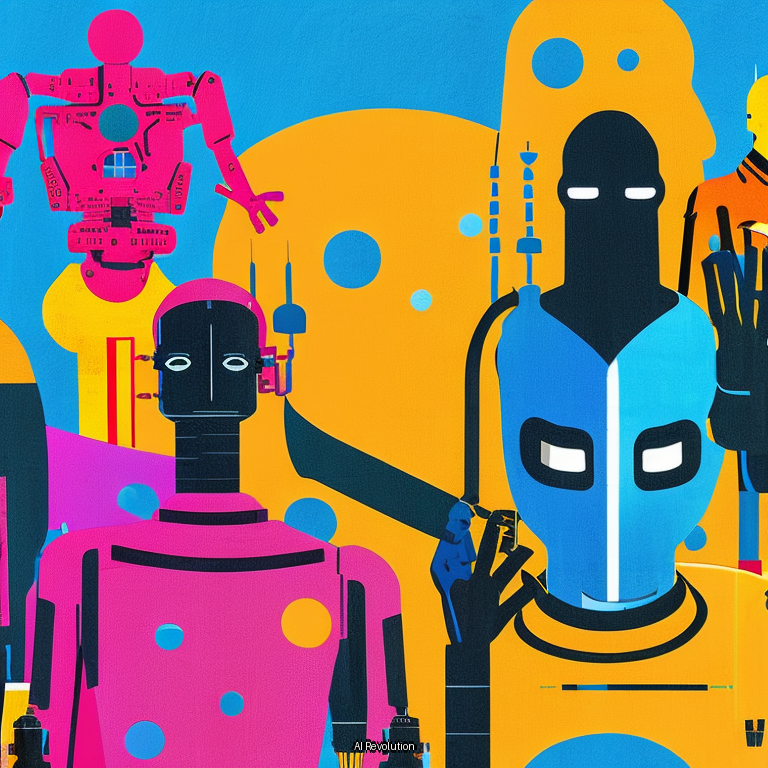

Thumbnail 1


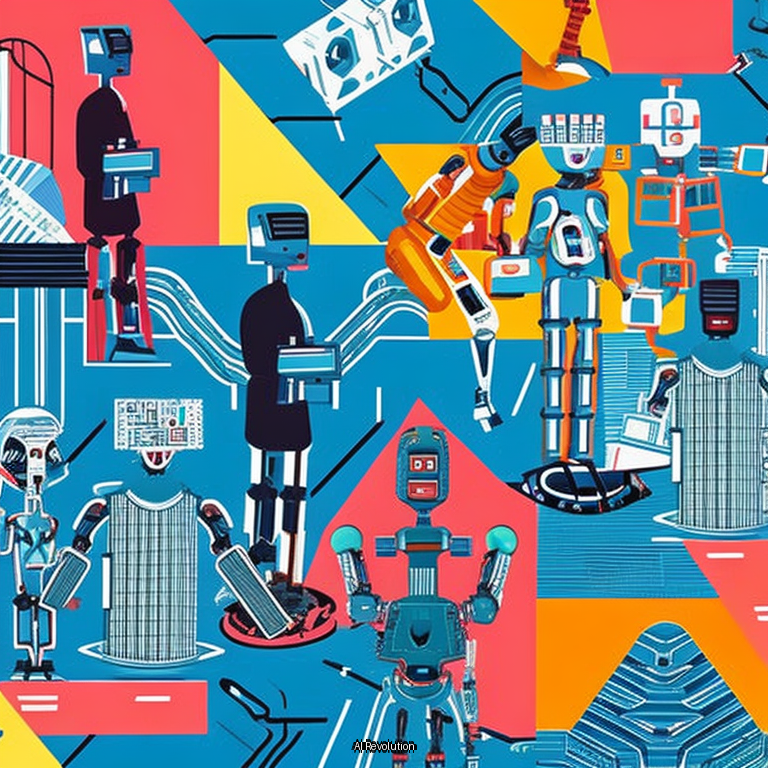

Thumbnail 2


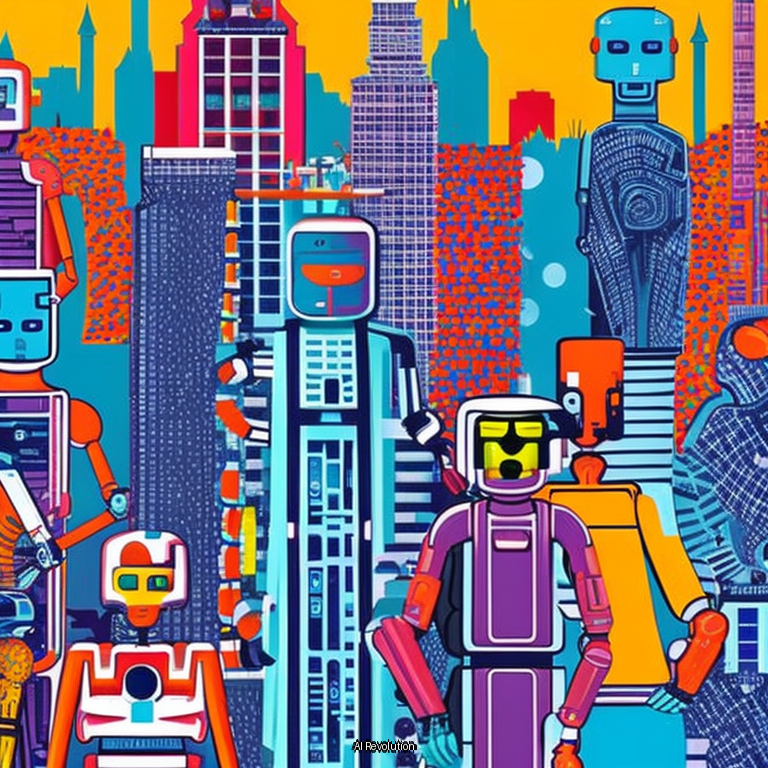

Thumbnail 3


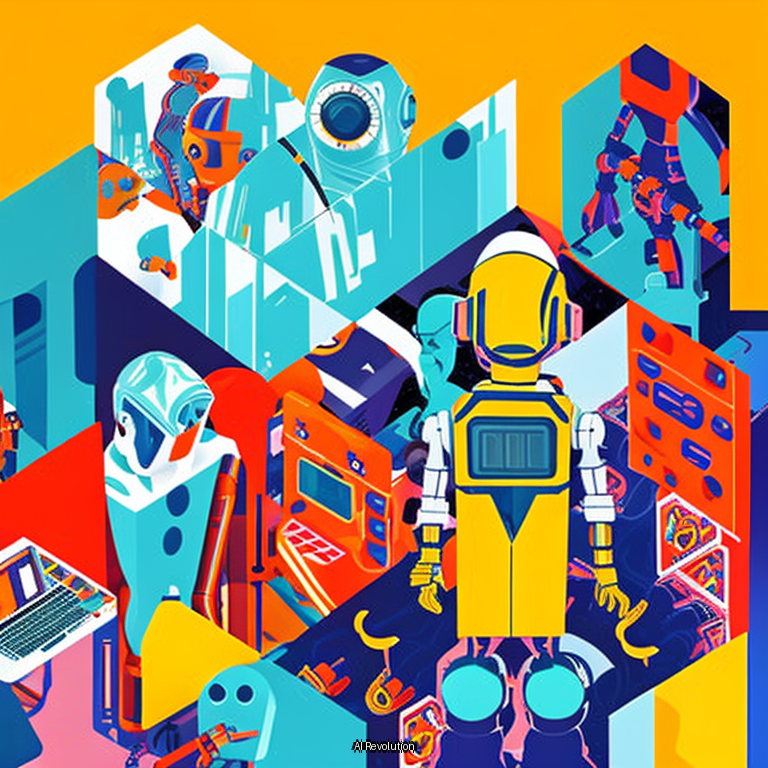

Thumbnail 4


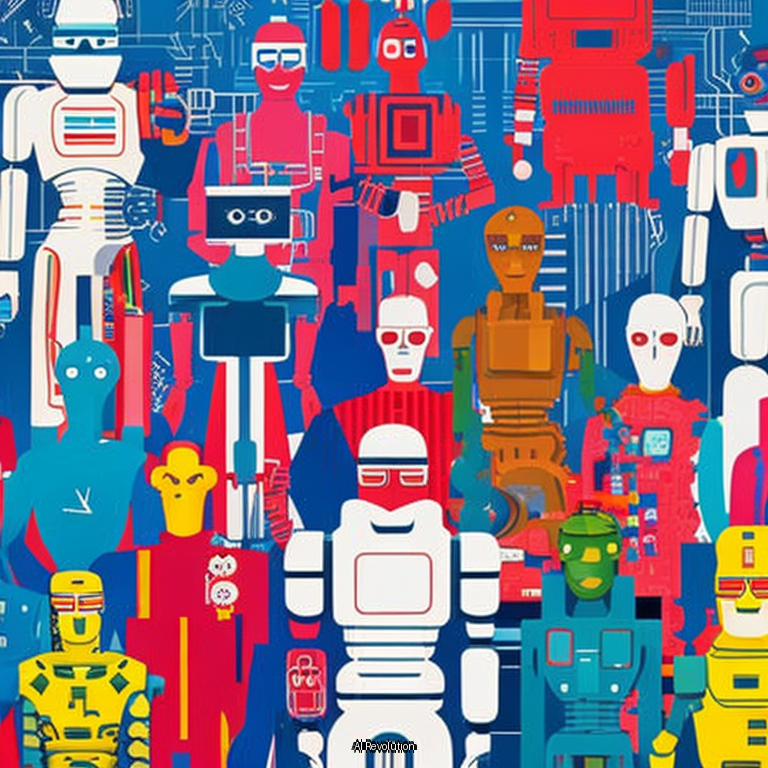

Thumbnail 5


In [1]:
import torch
from diffusers import StableDiffusionPipeline, DPMSolverMultistepScheduler
from PIL import Image, ImageDraw, ImageFont
import requests
import io

# Function to download and save an image
def download_image(url, filename):
    response = requests.get(url)
    with open(filename, 'wb') as f:
        f.write(response.content)

# Load the Stable Diffusion 2.1 model
model_id = "stabilityai/stable-diffusion-2-1"
pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float16)
pipe.scheduler = DPMSolverMultistepScheduler.from_config(pipe.scheduler.config)
pipe = pipe.to("cuda")

# Enable attention slicing for memory efficiency
pipe.enable_attention_slicing()

# Function to add text to image
def add_text_to_image(image, text, font_size=40, font_color=(255, 255, 255)):
    draw = ImageDraw.Draw(image)
    try:
        font = ImageFont.truetype("/usr/share/fonts/truetype/dejavu/DejaVuSans-Bold.ttf", font_size)
    except IOError:
        font = ImageFont.load_default()
    
    # Use textbbox instead of textsize
    bbox = draw.textbbox((0, 0), text, font=font)
    text_width = bbox[2] - bbox[0]
    text_height = bbox[3] - bbox[1]
    
    position = ((image.width - text_width) / 2, image.height - text_height - 20)
    
    # Draw text outline
    outline_color = (0, 0, 0)
    for adj in range(-3, 4):
        draw.text((position[0]+adj, position[1]), text, font=font, fill=outline_color)
        draw.text((position[0], position[1]+adj), text, font=font, fill=outline_color)
    
    # Draw text
    draw.text(position, text, font=font, fill=font_color)
    return image

# Function to generate thumbnails
def generate_thumbnails(title, concept_note, num_images=5):
    prompt = f"Thumbnail for '{title}'. {concept_note}"
    negative_prompt = "low quality, blurry, text, watermark"
    
    images = []
    for i in range(num_images):
        image = pipe(prompt=prompt, negative_prompt=negative_prompt, num_inference_steps=30, guidance_scale=7.5).images[0]
        image_with_text = add_text_to_image(image, title)
        images.append(image_with_text)
        image_with_text.save(f"thumbnail_{i+1}.png")
    
    return images

# Example usage
title = "AI Revolution"
concept_note = "Futuristic cityscape with robots and humans coexisting, vibrant colors, dynamic composition"
thumbnails = generate_thumbnails(title, concept_note)

print(f"Generated {len(thumbnails)} thumbnails.")

# Display thumbnails (if running in a Jupyter notebook)
for i, img in enumerate(thumbnails):
    display(img)
    print(f"Thumbnail {i+1}")
